# 1. IMPORTS / SETUP

In [3]:
import os
import sys
from starter import Starter

starter = Starter()
starter.start(lambda: os.chdir(os.path.join(os.getcwd(), '..')))


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score
import json
import time
import random
from typing import Dict, List, Tuple, Any
import warnings
import keras
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def reseed():
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_seed(42)
    random.seed(42)

from playgrounds.starter import Starter

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

Starter has been initialized.


# 2. LOADING AND PREPROCESSING DATA

Loading CIFAR-10 dataset...

Data loaded successfully!

Class distribution in training data:
  airplane: 3986 (10.0%)
  automobile: 3986 (10.0%)
  bird: 4048 (10.1%)
  cat: 3984 (10.0%)
  deer: 4003 (10.0%)
  dog: 3975 (9.9%)
  frog: 4020 (10.1%)
  horse: 4023 (10.1%)
  ship: 3997 (10.0%)
  truck: 3978 (9.9%)

Data shapes:
  Training: X=(40000, 32, 32, 3), y=(40000,)
  Validation: X=(10000, 32, 32, 3), y=(10000,)
  Test: X=(10000, 32, 32, 3), y=(10000,)

Sample data info:
  Image shape: (32, 32, 3)
  Pixel value range: [0.000, 1.000]
  First 5 training labels: [6 9 9 4 1]
  First 5 class names: ['frog', 'truck', 'truck', 'deer', 'automobile']

Displaying first 5 training images:


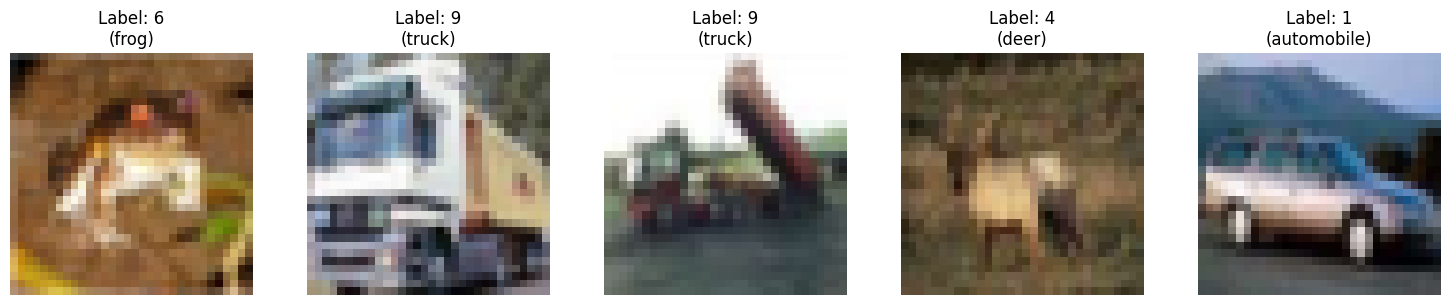


Data preprocessing completed successfully!


In [4]:
#!/usr/bin/env python3

# CIFAR-10 class names
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

def load_and_preprocess_data():
    """Load CIFAR-10 data and preprocess it"""
    print("Loading CIFAR-10 dataset...")
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    
    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Flatten labels
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Create validation split (4:1 ratio)
    # Split training data: 80% train, 20% validation
    split_idx = int(0.8 * len(x_train))
    
    x_val = x_train[split_idx:]
    y_val = y_train[split_idx:]
    x_train = x_train[:split_idx]
    y_train = y_train[:split_idx]
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def display_sample_images(x_data, y_data, num_samples=5):
    """Display sample images from the dataset"""
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[i])
        plt.title(f'Label: {y_data[i]}\n({CIFAR10_CLASSES[y_data[i]]})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load and prepare data
try:
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_preprocess_data()
    
    print(f"\nData loaded successfully!")
    
    # Show class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\nClass distribution in training data:")
    for class_id, count in zip(unique, counts):
        class_name = CIFAR10_CLASSES[class_id]
        print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")
        
    print(f"\nData shapes:")
    print(f"  Training: X={x_train.shape}, y={y_train.shape}")
    print(f"  Validation: X={x_val.shape}, y={y_val.shape}")
    print(f"  Test: X={x_test.shape}, y={y_test.shape}")
    
    # Display sample data info
    print(f"\nSample data info:")
    print(f"  Image shape: {x_train[0].shape}")
    print(f"  Pixel value range: [{x_train[0].min():.3f}, {x_train[0].max():.3f}]")
    print(f"  First 5 training labels: {y_train[:5]}")
    print(f"  First 5 class names: {[CIFAR10_CLASSES[label] for label in y_train[:5]]}")
    
    # Display first 5 images
    print(f"\nDisplaying first 5 training images:")
    display_sample_images(x_train, y_train, num_samples=5)
    
    print(f"\nData preprocessing completed successfully!")
        
except Exception as e:
    print(f"Error loading data: {e}")
    import traceback
    traceback.print_exc()
    raise e

# 3. SETUP EXPERIMENT RUNNER AND PLOT FUNCTION

In [5]:
#!/usr/bin/env python3

class KerasCNNExperiment:
    """Keras CNN experiment class for systematic hyperparameter analysis"""
    
    def __init__(self, x_train, y_train, x_val, y_val, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test

        self.base_layers = [
            # Conv2D block
            keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
            keras.layers.MaxPooling2D((2, 2)),
            
            # Second Conv2D block
            keras.layers.Conv2D(64, (3, 3), activation='relu'),
            keras.layers.MaxPooling2D((2, 2)),
            
            # Third Conv2D block
            keras.layers.Conv2D(128, (3, 3), activation='relu'),
            keras.layers.AveragePooling2D((2, 2)),
            
            # Flatten layer
            keras.layers.Flatten(),
            
            # Dense layers
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(10, activation='softmax')
        ]
        
        self.base_config = {
            'layers': self.base_layers,
            'batch_size': 32,
            'epochs': 30
        }
        
        print(f"Base configuration:")
        print(f"  Number of layers: {len(self.base_layers)}")
        print(f"  Batch size: {self.base_config['batch_size']}")
        print(f"  Epochs: {self.base_config['epochs']}")
    
    def create_keras_model(self, layers=None):
        """Create Keras CNN model with given configuration"""
        model = Sequential()

        if layers is None:
            layers = self.base_layers.copy()
        
        # Add layer from config
        for layer in layers:
            model.add(layer)
        
        # Compile model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_and_evaluate(self, config, experiment_name, file_name):
        """Train and evaluate a single configuration"""
        print(f"\n{'='*60}")
        print(f"Training: {experiment_name}")
        print(f"{'='*60}")
        
        start_time = time.time()
        
        # Create model
        model = self.create_keras_model(config['layers'])
        print(f"Model created with {model.count_params():,} parameters")

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-7
            )
        ]
        
        # Train model with validation monitoring
        print(f"Starting training for {config['epochs']} epochs...")
        history = model.fit(
            self.x_train, self.y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_data=(self.x_val, self.y_val),
            callbacks=callbacks,
            verbose=1
        )
            
        # Evaluate on test set
        print(f"Evaluating on test set...")
        test_loss, test_acc = model.evaluate(self.x_test, self.y_test, verbose=0)
        test_predictions = model.predict(self.x_test, verbose=0)
        test_pred_classes = np.argmax(test_predictions, axis=1)
        
        # Calculate macro F1-score
        test_f1_macro = f1_score(self.y_test, test_pred_classes, average='macro')
        
        # Save weights for from-scratch comparison
        weights_path = f"results/{file_name}.npz"
        os.makedirs("results", exist_ok=True)
        self.save_keras_weights(model, weights_path)
        
        training_time = time.time() - start_time
        
        print(f"\nResults for {experiment_name}:")
        print(f"  Training time: {training_time:.2f} seconds")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  Test F1-Score (macro): {test_f1_macro:.4f}")
        print(f"  Weights saved to: {weights_path}")
        
        return {
            'model': model,
            'history': history.history,
            'test_accuracy': test_acc,
            'test_f1_score': test_f1_macro,
            'weights_path': weights_path,
            'config': config,
            'training_time': training_time
        }
    
    def save_keras_weights(self, model: Sequential, filepath):
        """Save Keras weights in format compatible with from-scratch model"""
        print(f"Saving Keras weights to: {filepath}")
        
        try:

            # Get model architecture
            model_config = model.to_json()
    
            weights = model.get_weights()
            
            # Create a dictionary to store in npz format
            save_dict = {'architecture': model_config}
            
            # Add weights with numbered keys
            for i, weight in enumerate(weights):
                save_dict[f'weight_{i}'] = weight
            
            # Save to .npz file
            np.savez_compressed(filepath, **save_dict)
            print(f"\nModel architecture and weights saved as: {filepath}")
            
        except Exception as e:
            print(f"Error saving weights: {e}")
            import traceback
            traceback.print_exc()
            raise

# Initialize experiment runner
print("Initializing Keras experiment framework...")
keras_experiment = KerasCNNExperiment(
    x_train, y_train, x_val, y_val, x_test, y_test
)
print("Keras experiment runner initialized!")

Initializing Keras experiment framework...
Base configuration:
  Number of layers: 11
  Batch size: 32
  Epochs: 30
Keras experiment runner initialized!


In [11]:
def plot_training_history(results_dict, title_prefix="", save_path=None):
    """Plot training history for multiple experiments"""
    if not results_dict:
        print(f"No results to plot for {title_prefix}")
        return
        
    # Define colors
    colors = plt.cm.Set1(np.linspace(0, 1, len(results_dict)))
    
    # Plot 1: Training and Validation Accuracy
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    for i, (name, result) in enumerate(results_dict.items()):
        history = result['history']
        color = colors[i]
        ax1.plot(history['accuracy'], label=f'{name} (Train)', color=color, linewidth=2)
        ax1.plot(history['val_accuracy'], label=f'{name} (Val)', color=color, linestyle='--', linewidth=2)
    ax1.set_title(f'{title_prefix} Training & Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_accuracy.png", dpi=300, bbox_inches='tight')
        print(f"Accuracy plot saved to: {save_path}_accuracy.png")
    plt.show()
    
    # Plot 2: Training and Validation Loss
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    for i, (name, result) in enumerate(results_dict.items()):
        history = result['history']
        color = colors[i]
        ax2.plot(history['loss'], label=f'{name} (Train)', color=color, linewidth=2)
        ax2.plot(history['val_loss'], label=f'{name} (Val)', color=color, linestyle='--', linewidth=2)
    ax2.set_title(f'{title_prefix} Training & Validation Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_loss.png", dpi=300, bbox_inches='tight')
        print(f"Loss plot saved to: {save_path}_loss.png")
    plt.show()
    
    # Plot 3: Final Test Performance
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    names = list(results_dict.keys())
    accuracies = [results_dict[name]['test_accuracy'] for name in names]
    f1_scores = [results_dict[name]['test_f1_score'] for name in names]
    
    x = np.arange(len(names))
    width = 0.35
    bars1 = ax3.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
    bars2 = ax3.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='lightcoral')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax3.set_title(f'{title_prefix} Final Test Performance', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Configuration')
    ax3.set_ylabel('Score')
    ax3.set_xticks(x)
    ax3.set_xticklabels(names, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}_performance.png", dpi=300, bbox_inches='tight')
        print(f"Performance plot saved to: {save_path}_performance.png")
    plt.show()
    

# 4. EXPERIMENTS

## 4.1. Comparing Layer Counts

In [9]:
#!/usr/bin/env python3

# Test 3 different configuration of CNN layers
experiment_layers = [
    [
        # Conv2D layer
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5), 
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax') 
    ],

    [
        # Conv2D layer
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5), 
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax') 
    ],

    [
        # Conv2D layer
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5), 
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ]
]
layer_results = {}

for i, layer in enumerate(experiment_layers):
    
    config = keras_experiment.base_config.copy()
    config.update({
        'layers': layer,
    })
    
    experiment_name = f"cnn_layers_{i + 1}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Layer configuration: {i + 1}, Epochs: {config['epochs']}, Batch size: {config['batch_size']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name, f"cnn_layer_{i + 1}")
        layer_results[experiment_name] = result
        print(f"{experiment_name} completed successfully!")
    except Exception as e:
        print(f"Error in {experiment_name}: {e}")
        continue

# Compare results
print(f"\nCOMPARISON OF CNN LAYER COUNT:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(layer_results.keys()):
    result = layer_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if layer_results:
    best_layers = max(layer_results.keys(), key=lambda x: layer_results[x]['test_f1_score'])
    print(f"\nBest layer count config: {best_layers}")
    print(f"   F1-Score: {layer_results[best_layers]['test_f1_score']:.4f}")
    print(f"   Accuracy: {layer_results[best_layers]['test_accuracy']:.4f}")
    
    f1_scores = [layer_results[layers]['test_f1_score'] for layers in sorted(layer_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "Performance increases with more layers"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "Performance decreases with more layers"
        else:
            trend = "Performance remains stable across layer counts"
        print(f"   Trend: {trend}")
else:
    print("No successful layer experiments completed")
    best_layers = 1  


🔬 Experiment: cnn_layers_1
   Layer configuration: 1, Epochs: 30, Batch size: 32

Training: cnn_layers_1
Model created with 931,530 parameters
Starting training for 30 epochs...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.2873 - loss: 1.9084 - val_accuracy: 0.4981 - val_loss: 1.4171 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4494 - loss: 1.4974 - val_accuracy: 0.5400 - val_loss: 1.3582 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4944 - loss: 1.3847 - val_accuracy: 0.5643 - val_loss: 1.2484 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5246 - loss: 1.3132 - val_accuracy: 0.5630 - val_loss: 1.2366 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5342 - loss: 1.2716 - val_accuracy: 0.5730 - val_loss: 1.2065 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━

Accuracy plot saved to: results/plots/cnn_layer_analysis_accuracy.png


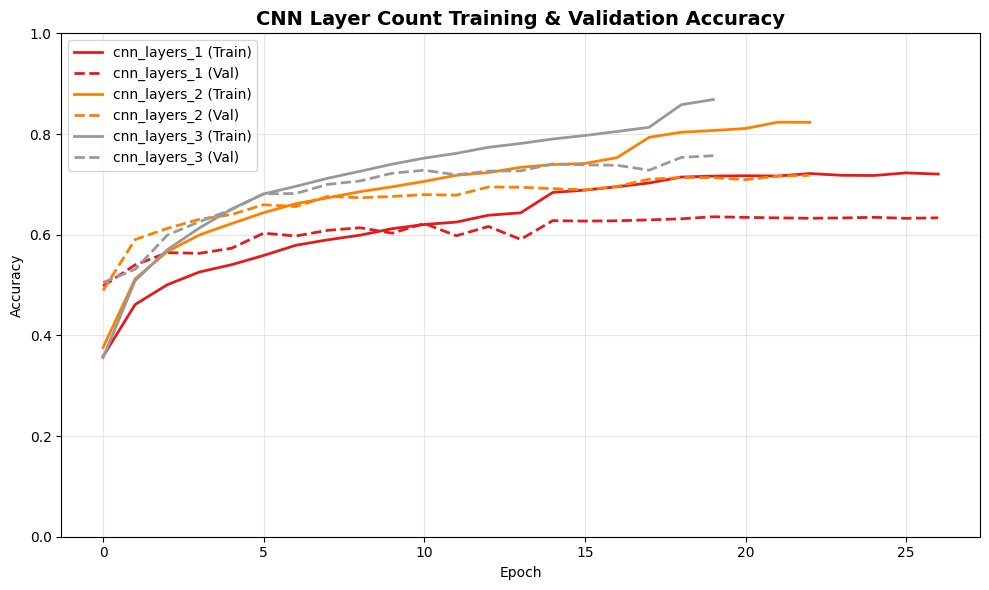

Loss plot saved to: results/plots/cnn_layer_analysis_loss.png


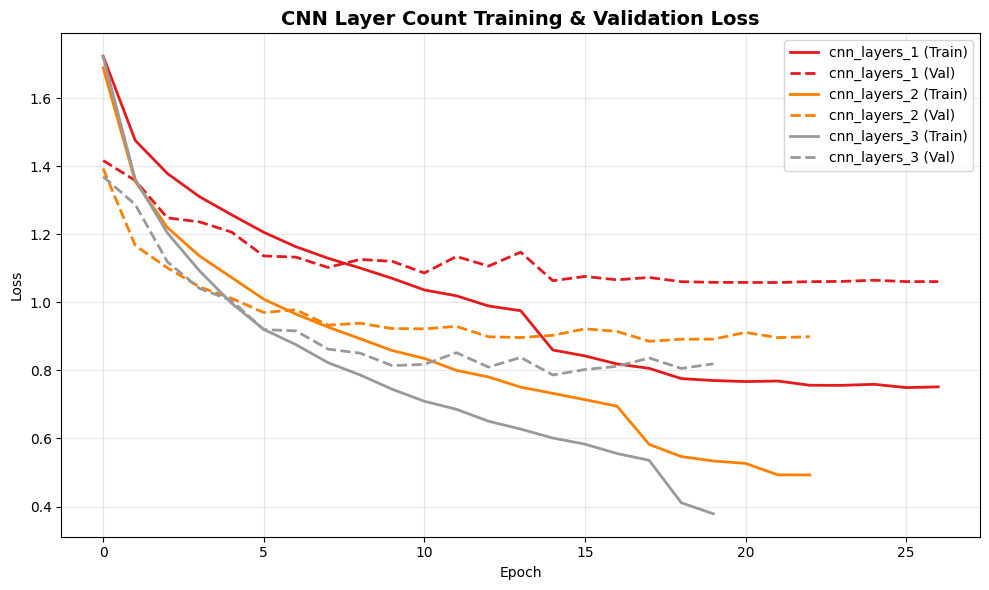

Performance plot saved to: results/plots/cnn_layer_analysis_performance.png


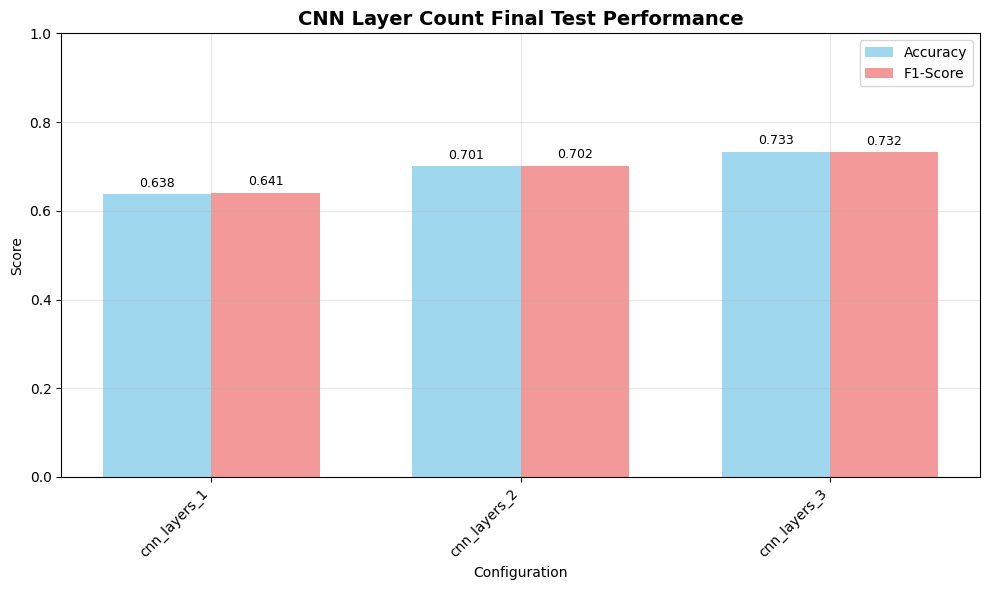

In [12]:
# Create results directory for plots
os.makedirs("results/plots", exist_ok=True)

# Plot layer count experiment result
plot_training_history(layer_results, "CNN Layer Count", "results/plots/cnn_layer_analysis")

## 4.2. Comparing Filter Counts

In [13]:
#!/usr/bin/env python3

# Test 3 different configuration of CNN filters
experiment_filters = [
    [
        # Conv2D block
        keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(16, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),  
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')  
    ],

    [
        # Conv2D block
        keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5), 
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ],

    [
        # Conv2D block
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5), 
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax') 
    ]
]
filter_results = {}

for i, filter_layer in enumerate(experiment_filters):
    
    config = keras_experiment.base_config.copy()
    config.update({
        'layers': filter_layer,
    })
    
    experiment_name = f"cnn_filters_{i + 1}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Filter configuration: {i + 1}, Epochs: {config['epochs']}, Batch size: {config['batch_size']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name, experiment_name)
        filter_results[experiment_name] = result
        print(f"{experiment_name} completed successfully!")
    except Exception as e:
        print(f"Error in {experiment_name}: {e}")
        continue

# Compare results
print(f"\nCOMPARISON OF CNN FILTER COUNT:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(filter_results.keys()):
    result = filter_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if filter_results:
    best_filters = max(filter_results.keys(), key=lambda x: filter_results[x]['test_f1_score'])
    print(f"\nBest filter count config: {best_filters}")
    print(f"   F1-Score: {filter_results[best_filters]['test_f1_score']:.4f}")
    print(f"   Accuracy: {filter_results[best_filters]['test_accuracy']:.4f}")
    
    # Analyze trend
    f1_scores = [filter_results[layers]['test_f1_score'] for layers in sorted(filter_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "Performance increases with more filters"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "Performance decreases with more filters"
        else:
            trend = "Performance remains stable across filter counts"
        print(f"   Trend: {trend}")
else:
    print("No successful filter experiments completed")
    best_filters = 1


🔬 Experiment: cnn_filters_1
   Filter configuration: 1, Epochs: 30, Batch size: 32

Training: cnn_filters_1
Model created with 31,450 parameters
Starting training for 30 epochs...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2358 - loss: 2.0266 - val_accuracy: 0.4413 - val_loss: 1.5233 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4289 - loss: 1.5571 - val_accuracy: 0.4744 - val_loss: 1.4612 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4833 - loss: 1.4346 - val_accuracy: 0.5286 - val_loss: 1.3153 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5141 - loss: 1.3490 - val_accuracy: 0.5380 - val_loss: 1.2826 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5347 - loss: 1.2912 - val_accuracy: 0.5620 - val_loss: 1.2184 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/

Accuracy plot saved to: results/plots/cnn_filter_count_analysis_accuracy.png


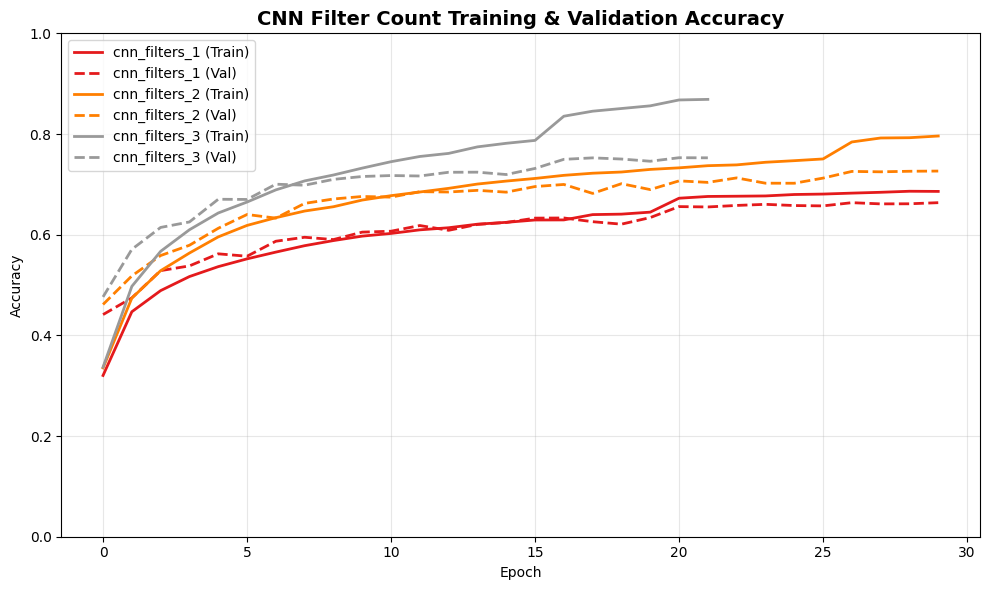

Loss plot saved to: results/plots/cnn_filter_count_analysis_loss.png


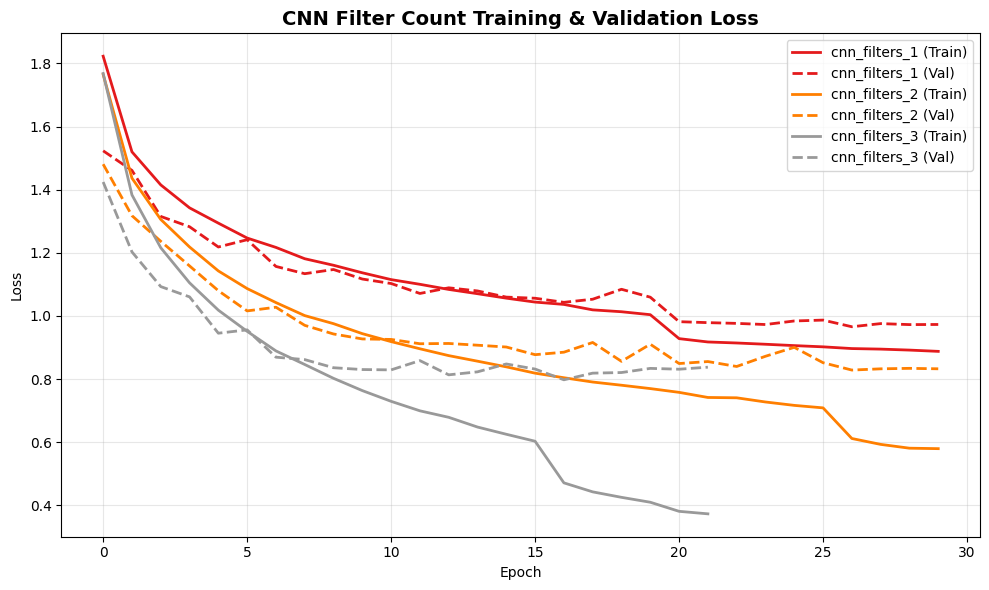

Performance plot saved to: results/plots/cnn_filter_count_analysis_performance.png


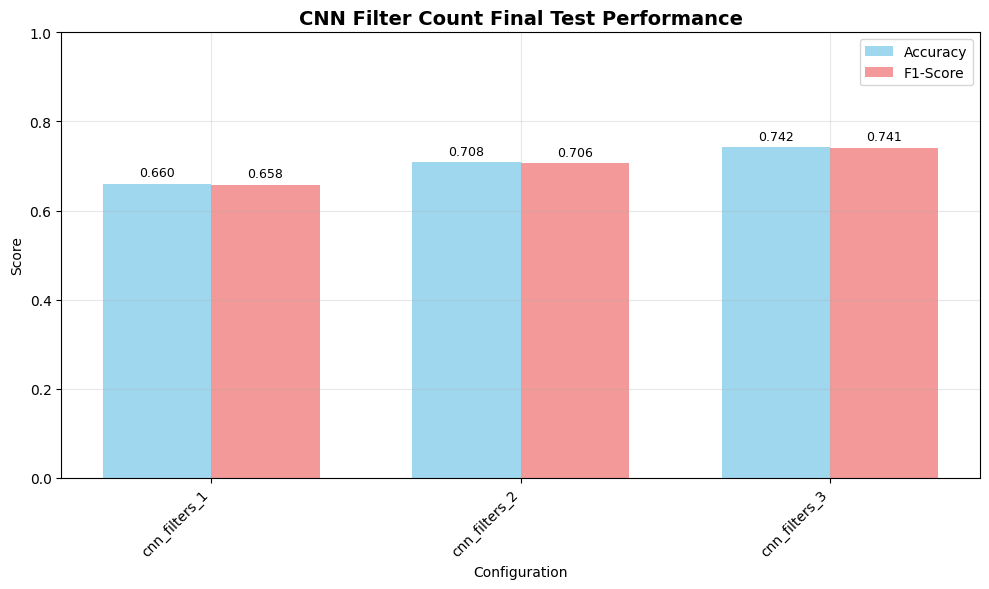

In [16]:
# Create results directory for plots
os.makedirs("results/plots", exist_ok=True)

# Plot filter count experiment result
plot_training_history(filter_results, "CNN Filter Count", "results/plots/cnn_filter_count_analysis")

## 4.3. Comparing Filter Sizes

In [14]:
#!/usr/bin/env python3

# Test 3 different configurations of CNN filter sizes
experiment_filter_sizes = [
    
    [
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ],

    [
        keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (5, 5), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ],

    [
        keras.layers.Conv2D(32, (7, 7), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Conv2D(64, (7, 7), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ]
]
filter_size_results = {}

for i, filter_layer in enumerate(experiment_filter_sizes):
    
    config = keras_experiment.base_config.copy()
    config.update({
        'layers': filter_layer,
    })
    
    experiment_name = f"cnn_filter_sizes_{i + 1}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Filter size config: {i + 1}, Epochs: {config['epochs']}, Batch size: {config['batch_size']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name, experiment_name)
        filter_size_results[experiment_name] = result
        print(f"{experiment_name} completed successfully!")
    except Exception as e:
        print(f"Error in {experiment_name}: {e}")
        continue

# Compare results
print(f"\nCOMPARISON OF CNN FILTER SIZE:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(filter_size_results.keys()):
    result = filter_size_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if filter_size_results:
    best_filter_sizes = max(filter_size_results.keys(), key=lambda x: filter_size_results[x]['test_f1_score'])
    print(f"\nBest filter size config: {best_filter_sizes}")
    print(f"   F1-Score: {filter_size_results[best_filter_sizes]['test_f1_score']:.4f}")
    print(f"   Accuracy: {filter_size_results[best_filter_sizes]['test_accuracy']:.4f}")
    
    # Analyze trend
    f1_scores = [filter_size_results[layers]['test_f1_score'] for layers in sorted(filter_size_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "Performance increases with bigger filters"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "Performance decreases with bigger filters"
        else:
            trend = "Performance remains stable across filter sizes"
        print(f"   Trend: {trend}")
else:
    print("No successful filter size experiments completed")
    best_filter_sizes = 1


🔬 Experiment: cnn_filter_sizes_1
   Filter size config: 1, Epochs: 30, Batch size: 32

Training: cnn_filter_sizes_1
Model created with 323,338 parameters
Starting training for 30 epochs...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2777 - loss: 1.9132 - val_accuracy: 0.5008 - val_loss: 1.3656 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4876 - loss: 1.4145 - val_accuracy: 0.5981 - val_loss: 1.1545 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5580 - loss: 1.2315 - val_accuracy: 0.6194 - val_loss: 1.0788 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5925 - loss: 1.1494 - val_accuracy: 0.6324 - val_loss: 1.0496 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6168 - loss: 1.0732 - val_accuracy: 0.6502 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━

Accuracy plot saved to: results/plots/cnn_filter_size_analysis_accuracy.png


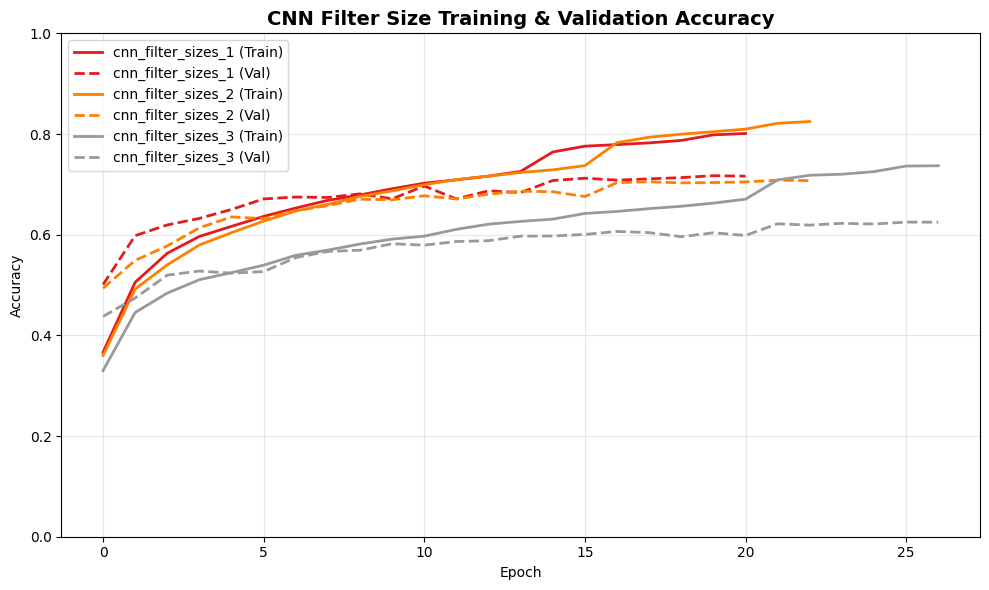

Loss plot saved to: results/plots/cnn_filter_size_analysis_loss.png


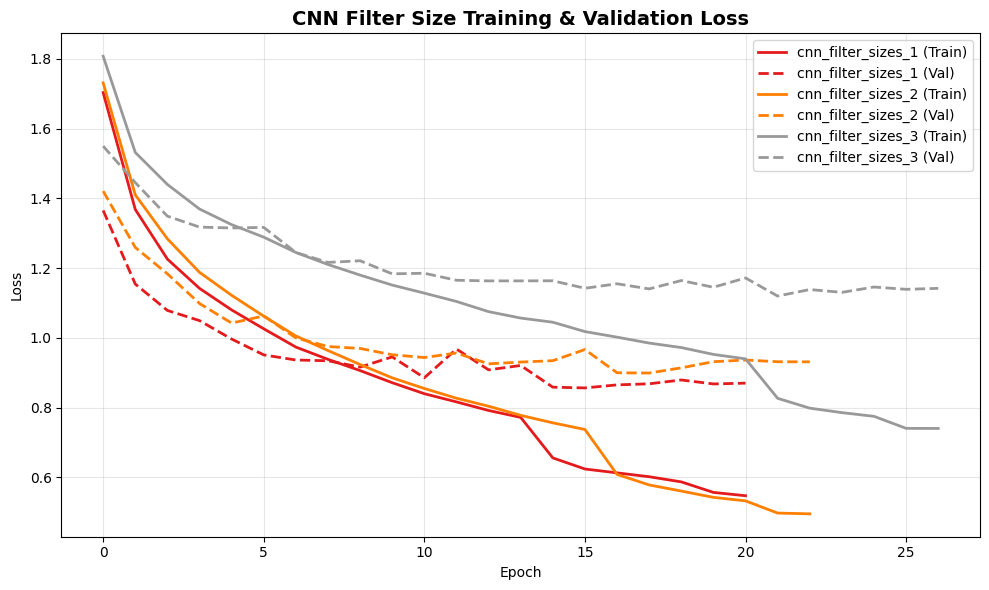

Performance plot saved to: results/plots/cnn_filter_size_analysis_performance.png


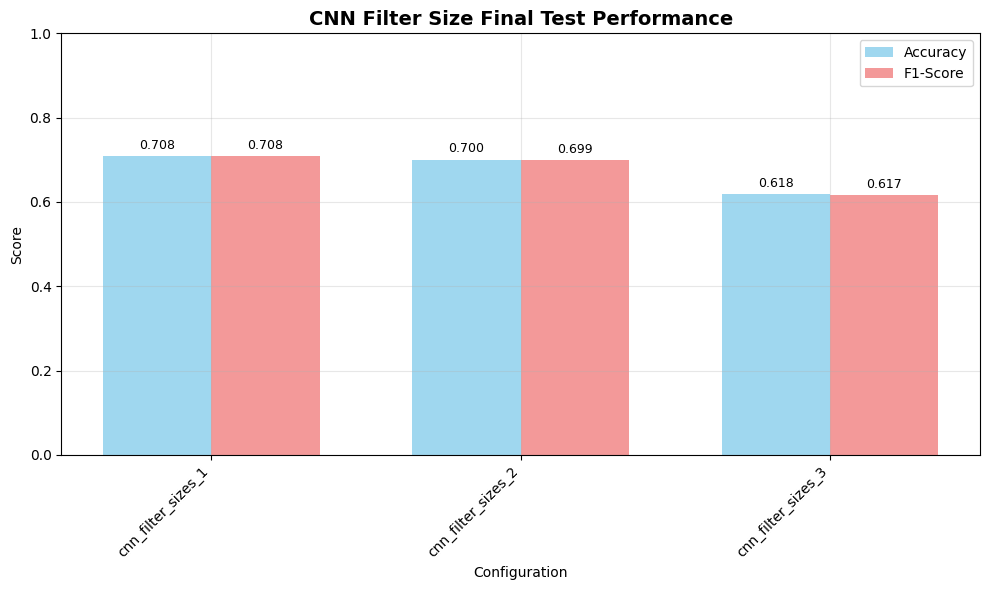

In [17]:
# Create results directory for plots
os.makedirs("results/plots", exist_ok=True)

# Plot filter size experiment result
plot_training_history(filter_size_results, "CNN Filter Size", "results/plots/cnn_filter_size_analysis")

## 4.4. Comparing Pooling Types

In [15]:
#!/usr/bin/env python3

# Test 2 different configurations of CNN pooling layers
experiment_pooling_types = [
    [
        # Conv2D block
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax') 
    ],

    [
        # Conv2D block
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Second Conv2D block
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Third Conv2D block
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.AveragePooling2D((2, 2)),
        
        # Flatten layer
        keras.layers.Flatten(),
        
        # Dense layers
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax') 
    ]
]
pooling_type_results = {}

for i, filter_layer in enumerate(experiment_pooling_types):
    
    config = keras_experiment.base_config.copy()
    config.update({
        'layers': filter_layer,
    })
    
    experiment_name = f"cnn_pooling_{i + 1}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Pooling config: {i + 1}, Epochs: {config['epochs']}, Batch size: {config['batch_size']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name, experiment_name)
        pooling_type_results[experiment_name] = result
        print(f"{experiment_name} completed successfully!")
    except Exception as e:
        print(f"Error in {experiment_name}: {e}")
        continue

# Compare results
print(f"\nCOMPARISON OF CNN POOLING TYPE:")
print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(pooling_type_results.keys()):
    result = pooling_type_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")

# Find best configuration
if pooling_type_results:
    best_pooling = max(pooling_type_results.keys(), key=lambda x: pooling_type_results[x]['test_f1_score'])
    print(f"\nBest pooling config: {best_pooling}")
    print(f"   F1-Score: {pooling_type_results[best_pooling]['test_f1_score']:.4f}")
    print(f"   Accuracy: {pooling_type_results[best_pooling]['test_accuracy']:.4f}")
    
    # Analyze trend
    f1_scores = [pooling_type_results[layers]['test_f1_score'] for layers in sorted(pooling_type_results.keys())]
    if len(f1_scores) >= 2:
        if f1_scores[-1] > f1_scores[0]:
            trend = "Average pooling is better"
        elif f1_scores[-1] < f1_scores[0]:
            trend = "Max pooling is better"
        else:
            trend = "Performance remains stable across 2 different pooling types"
        print(f"   Trend: {trend}")
else:
    print("No successful pooling experiments completed")
    best_pooling = 1 


🔬 Experiment: cnn_pooling_1
   Pooling config: 1, Epochs: 30, Batch size: 32

Training: cnn_pooling_1
Model created with 167,818 parameters
Starting training for 30 epochs...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2359 - loss: 1.9978 - val_accuracy: 0.4868 - val_loss: 1.4070 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4872 - loss: 1.4048 - val_accuracy: 0.5587 - val_loss: 1.2214 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5587 - loss: 1.2257 - val_accuracy: 0.5963 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5980 - loss: 1.1302 - val_accuracy: 0.6165 - val_loss: 1.0788 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 156s 125ms/step - accuracy: 0.6398 - loss: 1.0278 - val_accuracy: 0.6442 - val_loss: 1.0243 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 

Accuracy plot saved to: results/plots/cnn_pooling_type_analysis.png_accuracy.png


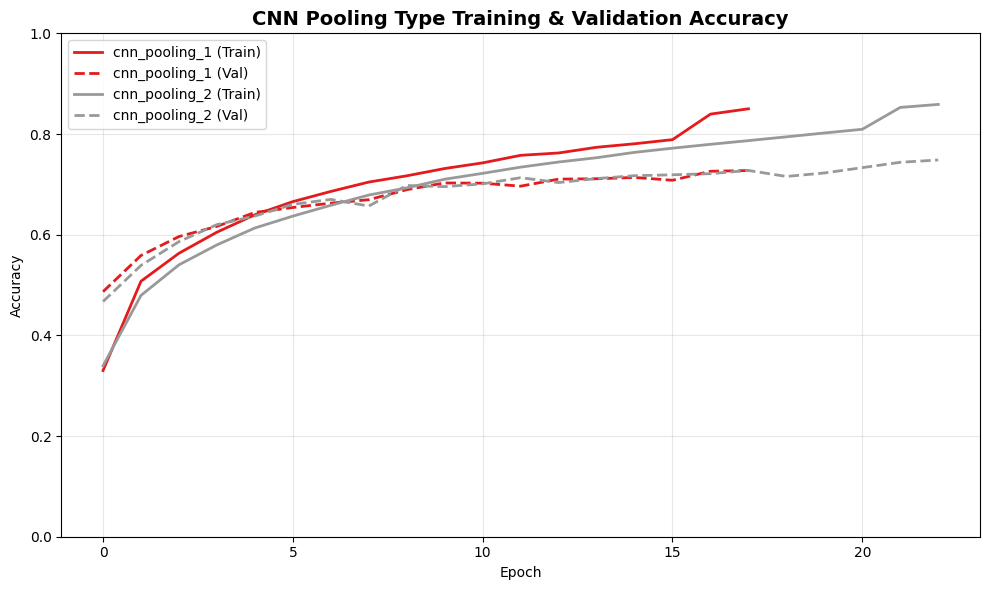

Loss plot saved to: results/plots/cnn_pooling_type_analysis.png_loss.png


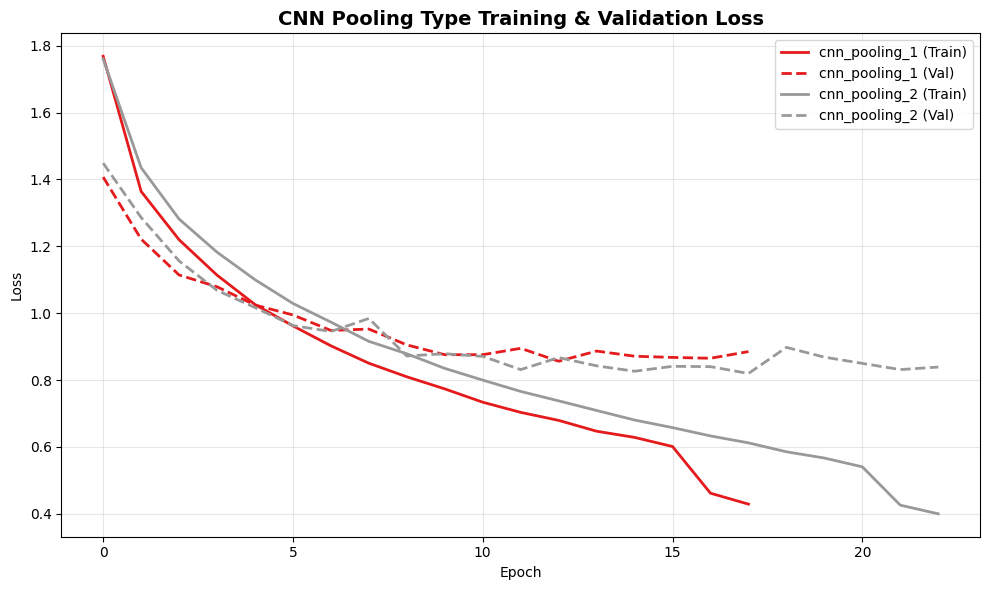

Performance plot saved to: results/plots/cnn_pooling_type_analysis.png_performance.png


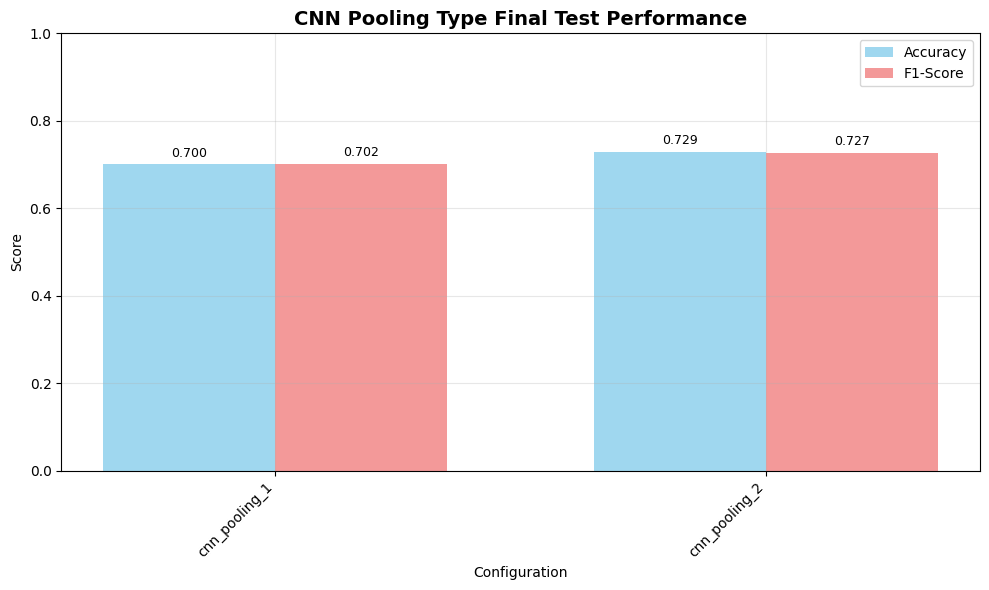

In [18]:
# Create results directory for plots
os.makedirs("results/plots", exist_ok=True)

# Plot pooling type experiment result
plot_training_history(pooling_type_results, "CNN Pooling Type", "results/plots/cnn_pooling_type_analysis.png")

# 5. COMPARE WITH FROM SCRATCH

In [30]:
#!/usr/bin/env python3

from importlib import reload
import models.cnn
reload(models.cnn)
from models.cnn import CNNFromScratch

def compare_keras_vs_scratch(x_test, y_test, keras_result, experiment_name):
    """Compare Keras model with from-scratch implementation"""
    
    try:
        # Get Keras model and config from the ACTUAL trained model
        keras_model = keras_result['model']
        config = keras_result['config']
        weights_path = keras_result['weights_path']
        
        print(f"Comparing experiment: {experiment_name}")
        print(f"Loading weights from: {weights_path}")
        
        # Verify weights file exists
        if not os.path.exists(weights_path):
            raise FileNotFoundError(f"Weights file not found: {weights_path}")
        
        # Create from-scratch model with EXACT same configuration
        print(f"Creating from-scratch model...")
        scratch_model = CNNFromScratch()
        
        # Load weights from the TRAINED model
        print(f"Loading trained weights into from-scratch model...")
        scratch_model.load_weights(weights_path)
        print(f"Weights loaded successfully!")
        
        # Set models to inference mode
        scratch_model.set_training(False)
        
        # Compare predictions on SMALL test set
        x_test_small = x_test[:100]
        y_test_small = y_test[:100]

        print(f"Comparing predictions on {len(x_test_small)} test samples...")
        
        # Get Keras predictions
        print(f"   Getting Keras predictions...")
        keras_predictions = keras_model.predict(x_test_small, verbose=0)
        
        # Get from-scratch predictions
        print(f"   Getting from-scratch predictions...")
        scratch_predictions = scratch_model.predict(x_test_small)
        
        # Ensure shapes match
        print(f"   Keras predictions shape: {keras_predictions.shape}")
        print(f"   Scratch predictions shape: {scratch_predictions.shape}")
        
        if keras_predictions.shape != scratch_predictions.shape:
            raise ValueError(f"Shape mismatch: Keras {keras_predictions.shape} vs Scratch {scratch_predictions.shape}")
        
        # Calculate metrics for both models
        keras_pred_classes = np.argmax(keras_predictions, axis=1)
        scratch_pred_classes = np.argmax(scratch_predictions, axis=1)
        
        keras_accuracy = np.mean(keras_pred_classes == y_test_small)
        scratch_accuracy = np.mean(scratch_pred_classes == y_test_small)
        
        keras_f1 = f1_score(y_test_small, keras_pred_classes, average='macro')
        scratch_f1 = f1_score(y_test_small, scratch_pred_classes, average='macro')
        
        # Calculate prediction differences
        max_diff = np.max(np.abs(keras_predictions - scratch_predictions))
        mean_diff = np.mean(np.abs(keras_predictions - scratch_predictions))
        
        # Calculate prediction similarity
        similarity = np.mean(np.isclose(keras_predictions, scratch_predictions, atol=1e-5))
        
        print(f"\nCOMPARISON RESULTS:")
        print(f"{'Metric':<25} {'Keras':<12} {'From-Scratch':<12} {'Difference':<12}")
        print("-"*63)
        print(f"{'Accuracy':<25} {keras_accuracy:<12.6f} {scratch_accuracy:<12.6f} {abs(keras_accuracy-scratch_accuracy):<12.6f}")
        print(f"{'F1-Score (macro)':<25} {keras_f1:<12.6f} {scratch_f1:<12.6f} {abs(keras_f1-scratch_f1):<12.6f}")
        print(f"{'Max Prediction Diff':<25} {max_diff:<12.8f}")
        print(f"{'Mean Prediction Diff':<25} {mean_diff:<12.8f}")
        print(f"{'Prediction Similarity':<25} {similarity:<12.6f}")
        
        # Show sample predictions for verification
        print("\nSample Predictions:")
        for i in range(5):
            predicted_class = np.argmax(scratch_predictions[i])
            true_class = y_test_small[i]
            confidence = scratch_predictions[i][predicted_class]
            
            print(f"Sample {i+1}: Predicted={CIFAR10_CLASSES[predicted_class]} "
                f"(confidence: {confidence:.3f}), True={CIFAR10_CLASSES[true_class]}")
        
        return {
            'keras_accuracy': keras_accuracy,
            'scratch_accuracy': scratch_accuracy,
            'keras_f1': keras_f1,
            'scratch_f1': scratch_f1,
            'max_difference': max_diff,
            'mean_difference': mean_diff,
            'prediction_similarity': similarity,
            'agreement_rate': np.mean(keras_pred_classes == scratch_pred_classes),
            'experiment_name': experiment_name
        }
        
    except Exception as e:
        print(f"Error in comparison for {experiment_name}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'keras_accuracy': 0.0,
            'scratch_accuracy': 0.0,
            'keras_f1': 0.0,
            'scratch_f1': 0.0,
            'max_difference': 999.0,
            'mean_difference': 999.0,
            'prediction_similarity': 0.0,
            'agreement_rate': 0.0,
            'experiment_name': experiment_name,
            'error': str(e)
        }

# Compare ACTUAL best configurations from each experiment
print("Comparing Keras vs From-Scratch implementations using TRAINED models:")

comparison_results = {}

# Compare best layer configuration
if layer_results and best_layers in layer_results.keys():
    print(f"\n{'='*60}")
    print(f"COMPARING BEST LAYER CONFIGURATION ({best_layers})")
    print(f"{'='*60}")
    best_layer_result = layer_results[best_layers]
    comparison_results['layers'] = compare_keras_vs_scratch(x_test, y_test, best_layer_result, f"best_layers_{best_layers}")

# Compare best filter configuration  
if filter_results and best_filters in filter_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST FILTER CONFIGURATION ({best_filters})")
    print(f"{'='*60}")
    best_filter_result = filter_results[best_filters]
    comparison_results['filter'] = compare_keras_vs_scratch(x_test, y_test, best_filter_result, f"best_filters_{best_filters}")

# # Compare best filter size configuration
if filter_size_results and best_filter_sizes in filter_size_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST FILTER SIZE CONFIGURATION ({best_filter_sizes})")
    print(f"{'='*60}")
    best_filter_size_result = filter_size_results[best_filter_sizes]
    comparison_results['filter_size'] = compare_keras_vs_scratch(x_test, y_test, best_filter_size_result, f"best_filter_size_{best_filter_sizes}")

# Compare best pooling type configuration
if pooling_type_results and best_pooling in pooling_type_results:
    print(f"\n{'='*60}")
    print(f"COMPARING BEST POOLING TYPE CONFIGURATION ({best_pooling})")
    print(f"{'='*60}")
    best_pooling_result = pooling_type_results[best_pooling]
    comparison_results['pooling'] = compare_keras_vs_scratch(x_test, y_test, best_pooling_result, f"best_pooling_{best_filter_sizes}")

# # Summary of all comparisons
print(f"\n{'='*60}")
print(f"IMPLEMENTATION VALIDATION SUMMARY")
print(f"{'='*60}")

print(f"{'Experiment':<20} {'Max Diff':<12} {'F1 Diff':<10} {'Agreement':<10}")
print("-"*75)

all_success = True
for category, result in comparison_results.items():
    if 'error' not in result:
        f1_diff = abs(result['keras_f1'] - result['scratch_f1'])
        print(f"{category:<20} {result['max_difference']:<12.6f} {f1_diff:<10.6f} {result['agreement_rate']:<10.4f}")
    else:
        print(f"{category:<20} {'ERROR':<12} {'ERROR':<10} {'ERROR':<10} {'FAILED'}")


Comparing Keras vs From-Scratch implementations using TRAINED models:

COMPARING BEST LAYER CONFIGURATION (cnn_layers_3)
Comparing experiment: best_layers_cnn_layers_3
Loading weights from: results/cnn_layer_3.npz
Creating from-scratch model...
Loading trained weights into from-scratch model...
Weights loaded successfully!
Comparing predictions on 100 test samples...
   Getting Keras predictions...
   Getting from-scratch predictions...
   Keras predictions shape: (100, 10)
   Scratch predictions shape: (100, 10)

COMPARISON RESULTS:
Metric                    Keras        From-Scratch Difference  
---------------------------------------------------------------
Accuracy                  0.810000     0.810000     0.000000    
F1-Score (macro)          0.800582     0.800582     0.000000    
Max Prediction Diff       0.00000076  
Mean Prediction Diff      0.00000002  
Prediction Similarity     1.000000    

Sample Predictions:
Sample 1: Predicted=cat (confidence: 0.804), True=cat
Sample 2: